# Data Preprocessing

Tasks
1.   Load Kaggle traffic sign data from drive
2.   Unpickle files
3.   Filter out classes not related to speed
4.   Normalize number of samples per class
5.   Split into train / val / test sets
6.   Shuffle datasets
7.   Resize
8.   Normalize pixel values
9.   Make pytorch dataloaders

In [ ]:
import pickle
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Data directory
# Change this as needed
data_dir = '/content/gdrive/My Drive/2020-21 School Year/APS360/APS360 Project/'

In [ ]:
# Data loaders

def get_data_loader(batch_size):
    ''' The Kaggle dataset is split into three pickle files: train.pickle,
    valid.pickle, and test.pickle.
    The function will combine the three datasets and resplit them such that the
    resulting split is approximately 70% training, 15% validation, and 15% testing.
    The function filters classes 0-8 only, as they are related to speed.
    The splitting ratio will be applied to each class, to avoid imbalance of 
    classes in the training/validation/testing samples.'''

    classes = ('Speed limit (20km/h)',
            'Speed limit (30km/h)',
            'Speed limit (50km/h)',
            'Speed limit (60km/h)',
            'Speed limit (70km/h)',
            'Speed limit (80km/h)',
            'End of speed limit (80km/h)',
            'Speed limit (100km/h)',
            'Speed limit (120km/h)')

    # load pickle files
    # will combine datasets from three seperate pikcle files
    
    with open(data_dir+'train.pickle', 'rb') as file:
        data1 = pickle.load(file)

    with open(data_dir+'valid.pickle', 'rb') as file:
        data2 = pickle.load(file)

    with open (data_dir+'test.pickle', 'rb') as file:
        data3 = pickle.load(file)

    images = np.concatenate((data1['features'], data2['features'], data3['features']))
    labels = np.concatenate((data1['labels'], data2['labels'], data3['labels']))
    
    # sort into classes
    class_images = []
    class_labels = []
    for i in range(9):
        class_indices = np.where(labels==i)
        #print(i, 'has', len(class_indices[0]), 'elements') # check number of samples for each class
        class_images.append(images[class_indices])
        class_labels.append(labels[class_indices])

    # normalize number of samples in each class
    desired_size=3000
    extra_samples = []
    extra_labels = []
    for i in range(9):
        # Randomly sample from the original class images to duplicate to extra
        # Duplicate enough samples to make the total for the class 3000
        extra_samples.append(
            class_images[i][np.random.randint(
                low=0,
                high=class_images[i].shape[0],
                size=desired_size-class_images[i].shape[0])])
        # Add random noise to create variation from originals
        noise = np.random.normal(0,1, extra_samples[i].size)
        noise = noise.reshape(extra_samples[i].shape[0],extra_samples[i].shape[1],extra_samples[i].shape[2],extra_samples[i].shape[3]).astype('uint8')
        extra_samples[i] = extra_samples[i]+noise

        # add labels for extra samples
        extra_labels.append(np.full(extra_samples[i].shape[0], i))

        # append to original
        class_images[i] = np.concatenate((class_images[i],extra_samples[i]))
        class_labels[i] = np.concatenate((class_labels[i],extra_labels[i]))

    # split into train /  val / test
    train_split = 0.7
    val_split = 0.85

    train_image_arrays = [class_images[i][0:int(train_split*class_images[i].shape[0])] for i in range(9)]
    train_label_arrays = [class_labels[i][0:int(train_split*class_images[i].shape[0])] for i in range(9)]
    train_images = np.concatenate(train_image_arrays)
    train_labels = np.concatenate(train_label_arrays)

    val_image_arrays = [class_images[i][int(train_split*class_images[i].shape[0]):int(val_split*class_images[i].shape[0])] for i in range(9)]
    val_label_arrays = [class_labels[i][int(train_split*class_images[i].shape[0]):int(val_split*class_images[i].shape[0])] for i in range(9)]
    val_images = np.concatenate(val_image_arrays)
    val_labels = np.concatenate(val_label_arrays)

    test_image_arrays = [class_images[i][int(val_split*class_images[i].shape[0]):] for i in range(9)]
    test_label_arrays = [class_labels[i][int(val_split*class_images[i].shape[0]):] for i in range(9)]
    test_images = np.concatenate(test_image_arrays)
    test_labels = np.concatenate(test_label_arrays)

    # shuffle
    np.random.seed(9001)
    indices = list(range(train_images.shape[0]))
    np.random.shuffle(indices)
    train_images = train_images[indices]
    train_labels = train_labels[indices]
    
    indices = list(range(val_images.shape[0]))
    np.random.shuffle(indices)
    val_images = val_images[indices]
    val_labels = val_labels[indices]
   
    indices = list(range(test_images.shape[0]))
    np.random.shuffle(indices)
    test_images = test_images[indices]
    test_labels = test_labels[indices]

    # make into torch datasets
    train_image_tensor = torch.Tensor(train_images.transpose(0,3,1,2))
    train_label_tensor = torch.Tensor(train_labels)
    
    val_image_tensor = torch.Tensor(val_images.transpose(0,3,1,2))
    val_label_tensor = torch.Tensor(val_labels)
    
    test_image_tensor = torch.Tensor(test_images.transpose(0,3,1,2))
    test_label_tensor = torch.Tensor(test_labels)
   
    trainset = TensorDataset(train_image_tensor, train_label_tensor)
    valset = TensorDataset(val_image_tensor, val_label_tensor)
    testset = TensorDataset(test_image_tensor, test_label_tensor)

    # resize and normalization
    transform = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    #trainset.transform = transform
    #valset.transform = transform
    #testset.transform = transform

    # make data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        num_workers=1)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        num_workers=1)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        num_workers=1)
    
    return train_loader, val_loader, test_loader, classes 

In [ ]:
batch_size = 32
train_loader, val_loader, test_loader, classes = get_data_loader (batch_size)
print (classes)
print (len(train_loader))
print (len(val_loader))
print (len(test_loader))

('Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)')
591
127
127


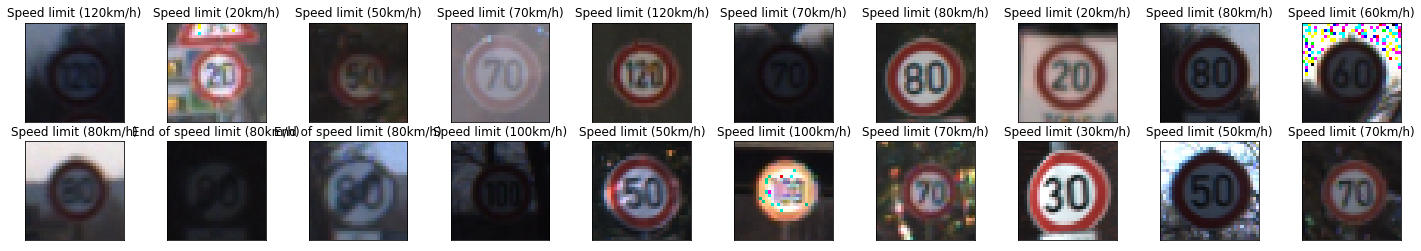

In [ ]:
# Check one batch
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy().astype(int) # convert images to numpy for display
labels = labels.int()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
# close all figures to prevent memory leak
plt.close('all')

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)//(max_val - min_val)             #this is kinda brilliant
    return norm_labels




#TRAIN

Tasks:
 - Calculate training accuracy
 - Calculate training loss
 - Calculate validation accuracy
 - Calculate validation loss
 - Store weights in epoch files (we may have to be smart about WHERE we're saving this so that we don't clutter up the drive)
 - Get accuracy of model after training is complete
 - Plot everything


In [ ]:
def train(model, train_loader, val_loader, batch_size=27, num_epochs=21, learning_rate = 0.001):

    torch.manual_seed(500)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    # training
    print ("Training Started...")
    if torch.cuda.is_available():
        print("U S I N G   C U D A ")

    for epoch in range(num_epochs):                                     # the number of iterations
        sum_train_loss = 0.0
        sum_val_loss = 0.0

        n = 0                                                           # Number of training iterations in this epoch
        m = 0                                                           # Number of validation iterations in this epoch

        for imgs, labels in iter(train_loader):
                
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)                                           # forward pass
            loss = criterion(out, labels.long())                               # compute the total loss
            loss.backward()                                             # backward pass (compute parameter updates)
            optimizer.step()                                            # make the updates for each parameter
            optimizer.zero_grad()                                       # a clean up step for PyTorch
            sum_train_loss += loss.item() 
            n += 1
        
        for imgs, labels in iter(val_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()                                    # cudafication for speeeeed

            out = model(imgs)                                            
            loss = criterion(out, labels.long())                               # compute loss with Cross Entropy
            sum_val_loss += loss.item()
            m += 1

        # track accuracy and loss
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))
        train_loss.append(sum_train_loss/n)
        val_loss.append(sum_val_loss/m)

        ################################################################################################################
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch+1) 
        torch.save(model.state_dict(), model_path)
        print('epoch: ', epoch,'training acc: ', train_acc[-1],'val acc: ', val_acc[-1],'training loss: ', train_loss[-1],'val loss: ', val_loss[-1])

    return train_acc, val_acc, train_loss, val_loss

def get_accuracy(model, data_loader):

  correct = 0
  total = 0
  for imgs, labels in data_loader:
      
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

      output = model(imgs)
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]

  return correct / total




def plot_training_curve(train_acc, val_acc, train_loss, val_loss):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt

    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

#BASELINE TRAINING

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim                                                     # For gradient descent
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class BaseANN(nn.Module):
  
  def __init__(self):
    super(BaseANN, self).__init__()

    self.name = "BaseANN"
    self.num_classes = 9

    #model layers
    self.fc1 = nn.Linear(32*32*3, 32)
    self.fc2 = nn.Linear(32, self.num_classes)
  
  def forward(self, x):
    #flatten image for input into fc layers
    x = x.view(-1, 32*32*3)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1)

    return x

#Hyperparameter Tuning:

Training Started...
U S I N G   C U D A 
epoch:  0 training acc:  0.15925925925925927 val acc:  0.17037037037037037 training loss:  8.096337094500258 val loss:  3.3408625200390816
epoch:  1 training acc:  0.15084656084656084 val acc:  0.1417283950617284 training loss:  2.387978985502913 val loss:  2.2587592229247093
epoch:  2 training acc:  0.1547089947089947 val acc:  0.14716049382716048 training loss:  2.184168069749265 val loss:  2.2235593646764755
epoch:  3 training acc:  0.16433862433862434 val acc:  0.1523456790123457 training loss:  2.155098575192529 val loss:  2.215673729777336
epoch:  4 training acc:  0.17624338624338623 val acc:  0.1582716049382716 training loss:  2.1241066826356425 val loss:  2.188247613608837
epoch:  5 training acc:  0.1939153439153439 val acc:  0.17135802469135802 training loss:  2.0905723305972845 val loss:  2.1570746675133705
epoch:  6 training acc:  0.20476190476190476 val acc:  0.18518518518518517 training loss:  2.0614272734603367 val loss:  2.1344232

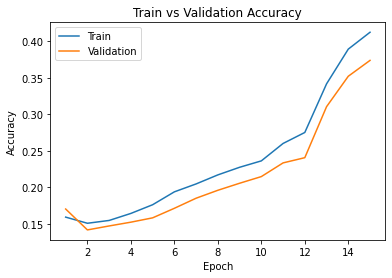

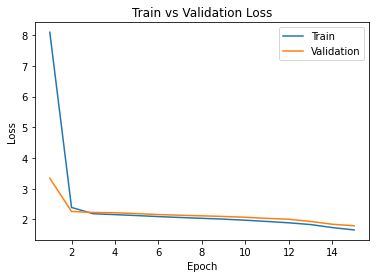

In [ ]:
model1 = BaseANN()
use_cuda = False

batch_size = 128
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model1, train_loader, val_loader, batch_size=128, num_epochs=15, learning_rate = 0.00001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Model is underfitting, both train and val loss are low.

Training Started...
U S I N G   C U D A 
epoch:  0 training acc:  0.14264550264550266 val acc:  0.14296296296296296 training loss:  7.131617668512705 val loss:  2.3019504249095917
epoch:  1 training acc:  0.15306878306878308 val acc:  0.14938271604938272 training loss:  2.220419527711095 val loss:  2.209401585161686
epoch:  2 training acc:  0.16111111111111112 val acc:  0.15555555555555556 training loss:  2.1802436306669906 val loss:  2.1834071427583694
epoch:  3 training acc:  0.164021164021164 val acc:  0.15530864197530864 training loss:  2.1566891186946147 val loss:  2.166357807815075
epoch:  4 training acc:  0.17132275132275132 val acc:  0.16617283950617284 training loss:  2.1338969646273434 val loss:  2.147640347480774
epoch:  5 training acc:  0.17783068783068784 val acc:  0.17382716049382715 training loss:  2.1107289911927403 val loss:  2.1267651319503784
epoch:  6 training acc:  0.18677248677248678 val acc:  0.1814814814814815 training loss:  2.0859210620055326 val loss:  2.1199

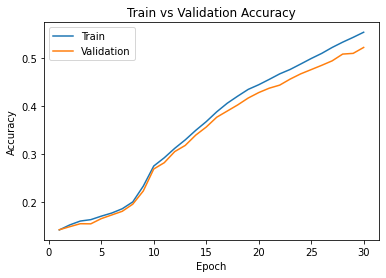

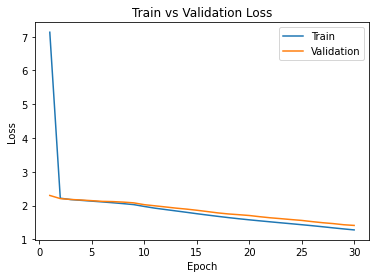

In [ ]:
#more epochs to increase accuracy/reduce loss

model2 = BaseANN()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model2, train_loader, val_loader, batch_size=128, num_epochs=30, learning_rate = 0.00001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...
U S I N G   C U D A 
epoch:  0 training acc:  0.11095238095238096 val acc:  0.1108641975308642 training loss:  5.388014300449474 val loss:  2.2025095969438553
epoch:  1 training acc:  0.1111111111111111 val acc:  0.1108641975308642 training loss:  2.202562232275267 val loss:  2.202214077115059
epoch:  2 training acc:  0.1111111111111111 val acc:  0.1108641975308642 training loss:  2.2021990176793693 val loss:  2.201960653066635
epoch:  3 training acc:  0.1111111111111111 val acc:  0.1108641975308642 training loss:  2.2018661917866886 val loss:  2.2016886323690414
epoch:  4 training acc:  0.1111111111111111 val acc:  0.1108641975308642 training loss:  2.201544445914191 val loss:  2.2014330327510834
epoch:  5 training acc:  0.11105820105820106 val acc:  0.1108641975308642 training loss:  2.201235191242115 val loss:  2.201170101761818
epoch:  6 training acc:  0.11105820105820106 val acc:  0.1108641975308642 training loss:  2.200953693003268 val loss:  2.200952932238579

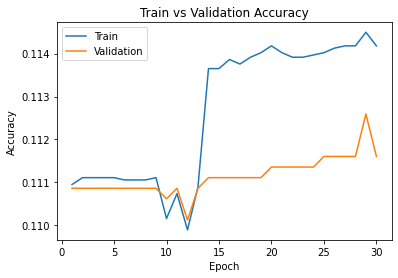

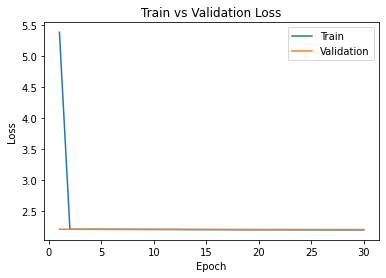

In [ ]:
#increasing batch size and learning rate

batch_size = 256
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

model3 = BaseANN()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model3, train_loader, val_loader, batch_size=256, num_epochs=30, learning_rate = 0.0001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...
U S I N G   C U D A 
epoch:  0 training acc:  0.15957671957671957 val acc:  0.15259259259259259 training loss:  9.425501942634583 val loss:  4.760327190160751
epoch:  1 training acc:  0.18851851851851853 val acc:  0.1782716049382716 training loss:  2.83140367269516 val loss:  2.254886083304882
epoch:  2 training acc:  0.20645502645502645 val acc:  0.2017283950617284 training loss:  2.167328053229564 val loss:  2.1697077602148056
epoch:  3 training acc:  0.22291005291005292 val acc:  0.21555555555555556 training loss:  2.111359416633039 val loss:  2.1262101866304874
epoch:  4 training acc:  0.23084656084656086 val acc:  0.2254320987654321 training loss:  2.073980724489367 val loss:  2.090551517903805
epoch:  5 training acc:  0.23814814814814814 val acc:  0.23679012345679012 training loss:  2.0466554027956887 val loss:  2.0574803575873375
epoch:  6 training acc:  0.24312169312169313 val acc:  0.24345679012345678 training loss:  2.024282693057447 val loss:  2.032763935

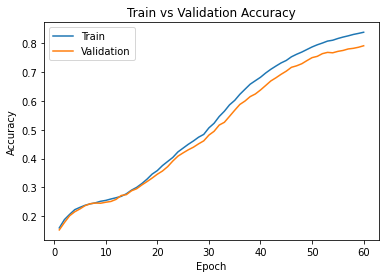

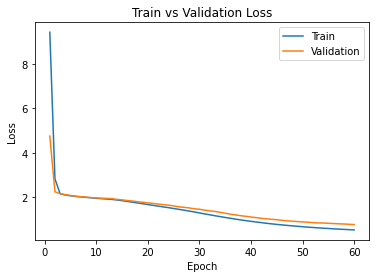

In [ ]:
#keeping original learning rate and batch size, increasing epochs

model4 = BaseANN()
use_cuda = False

batch_size = 128
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model4, train_loader, val_loader, batch_size=128, num_epochs=60, learning_rate = 0.00001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...
U S I N G   C U D A 
epoch:  0 training acc:  0.23333333333333334 val acc:  0.21777777777777776 training loss:  6.60860979718131 val loss:  4.2134082689881325
epoch:  1 training acc:  0.29947089947089944 val acc:  0.28271604938271605 training loss:  3.2781028618683687 val loss:  3.253260873258114
epoch:  2 training acc:  0.20851851851851852 val acc:  0.19012345679012346 training loss:  2.385628477947132 val loss:  2.2266306579113007
epoch:  3 training acc:  0.27174603174603174 val acc:  0.24074074074074073 training loss:  2.0625038308066292 val loss:  2.130404584109783
epoch:  4 training acc:  0.32915343915343914 val acc:  0.3037037037037037 training loss:  1.9632926599399463 val loss:  2.0355150252580643
epoch:  5 training acc:  0.36756613756613754 val acc:  0.3362962962962963 training loss:  1.8699643281666007 val loss:  1.9429389461874962
epoch:  6 training acc:  0.4 val acc:  0.3671604938271605 training loss:  1.7821109931211214 val loss:  1.8628149405121803
epo

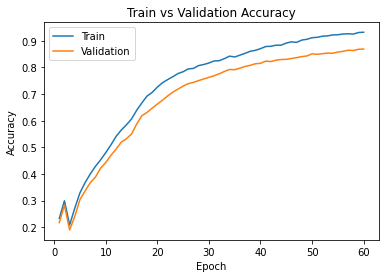

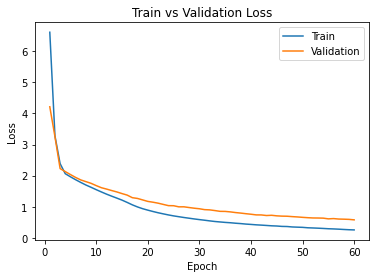

In [ ]:
#increasing learning rate

model4 = BaseANN()
use_cuda = False

batch_size = 128
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model4, train_loader, val_loader, batch_size=128, num_epochs=60, learning_rate = 0.00002)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

#Determining Accuracy for Different Classes

In [ ]:
#modified dataloader for testing accuracy of class subsets

def get_class_dataloader(batch_size, ts_class):
    ''' The Kaggle dataset is split into three pickle files: train.pickle,
    valid.pickle, and test.pickle.
    The function will combine the three datasets and resplit them such that the
    resulting split is approximately 70% training, 15% validation, and 15% testing.
    The function filters classes 0-8 only, as they are related to speed.
    The splitting ratio will be applied to each class, to avoid imbalance of 
    classes in the training/validation/testing samples.'''

    classes = ('Speed limit (20km/h)',
            'Speed limit (30km/h)',
            'Speed limit (50km/h)',
            'Speed limit (60km/h)',
            'Speed limit (70km/h)',
            'Speed limit (80km/h)',
            'End of speed limit (80km/h)',
            'Speed limit (100km/h)',
            'Speed limit (120km/h)')

    # load pickle files
    # will combine datasets from three seperate pikcle files
    
    with open(data_dir+'train.pickle', 'rb') as file:
        data1 = pickle.load(file)

    with open(data_dir+'valid.pickle', 'rb') as file:
        data2 = pickle.load(file)

    with open (data_dir+'test.pickle', 'rb') as file:
        data3 = pickle.load(file)

    images = np.concatenate((data1['features'], data2['features'], data3['features']))
    labels = np.concatenate((data1['labels'], data2['labels'], data3['labels']))
    
    # sort into classes
    class_images = []
    class_labels = []
    for i in range(9):
        class_indices = np.where(labels==i)
        #print(i, 'has', len(class_indices[0]), 'elements') # check number of samples for each class
        class_images.append(images[class_indices])
        class_labels.append(labels[class_indices])

    # normalize number of samples in each class
    desired_size=3000
    extra_samples = []
    extra_labels = []
    for i in range(9):
        # Randomly sample from the original class images to duplicate to extra
        # Duplicate enough samples to make the total for the class 3000
        extra_samples.append(
            class_images[i][np.random.randint(
                low=0,
                high=class_images[i].shape[0],
                size=desired_size-class_images[i].shape[0])])
        # Add random noise to create variation from originals
        noise = np.random.normal(0,1, extra_samples[i].size)
        noise = noise.reshape(extra_samples[i].shape[0],extra_samples[i].shape[1],extra_samples[i].shape[2],extra_samples[i].shape[3]).astype('uint8')
        extra_samples[i] = extra_samples[i]+noise

        # add labels for extra samples
        extra_labels.append(np.full(extra_samples[i].shape[0], i))

        # append to original
        class_images[i] = np.concatenate((class_images[i],extra_samples[i]))
        class_labels[i] = np.concatenate((class_labels[i],extra_labels[i]))

    train_split=0.7

    train_image_arrays = [class_images[ts_class][0:int(train_split*class_images[ts_class].shape[0])]]
    train_label_arrays = [class_labels[ts_class][0:int(train_split*class_images[ts_class].shape[0])]]
    train_images = np.concatenate(train_image_arrays)
    train_labels = np.concatenate(train_label_arrays)

    # make into torch datasets
    train_image_tensor = torch.Tensor(train_images.transpose(0,3,1,2))
    train_label_tensor = torch.Tensor(train_labels)
   
    trainset = TensorDataset(train_image_tensor, train_label_tensor)

    # resize and normalization
    transform = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    #trainset.transform = transform
    #valset.transform = transform
    #testset.transform = transform

    # make dataloader
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        num_workers=1)
    
    return train_loader

In [ ]:
#determine accuracy of best model on each of the 9 classes

classes = ('Speed limit (20km/h)',
            'Speed limit (30km/h)',
            'Speed limit (50km/h)',
            'Speed limit (60km/h)',
            'Speed limit (70km/h)',
            'Speed limit (80km/h)',
            'End of speed limit (80km/h)',
            'Speed limit (100km/h)',
            'Speed limit (120km/h)')

for ts_class in range(9):
  data_loader = get_class_dataloader(128, ts_class)
  print(f"class: {classes[ts_class]}")
  print(f"accuracy: {get_accuracy(model4, data_loader)}")


class: Speed limit (20km/h)
accuracy: 0.9738095238095238
class: Speed limit (30km/h)
accuracy: 0.8942857142857142
class: Speed limit (50km/h)
accuracy: 0.9333333333333333
class: Speed limit (60km/h)
accuracy: 0.91
class: Speed limit (70km/h)
accuracy: 0.9452380952380952
class: Speed limit (80km/h)
accuracy: 0.9085714285714286
class: End of speed limit (80km/h)
accuracy: 0.9923809523809524
class: Speed limit (100km/h)
accuracy: 0.8828571428571429
class: Speed limit (120km/h)
accuracy: 0.9080952380952381
